In [1]:
# %%bash
# !(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
# rm -rf hw2
# git clone https://github.com/mit-6864/hw2.git

In [2]:
import sys
sys.path.append("hw2")

import csv
import itertools as it
import numpy as np
import sklearn.decomposition
from tqdm import tqdm

import lab_util

# Introduction

In this notebook, you will find code scaffolding for the implementation portion of Homework 1. There are certain parts of the scaffolding marked with `# Your code here!` comments where you can fill in code to perform the specified tasks. You should be able to complete this assignment without changing any of the scaffolding code, just writing code to fill in the scaffolding and run experiments. Make sure to read the text between cells for certain implementation details. Please submit the notebook with all code cells run.

This notebook can be done independently of the handout and will be graded based on the code and cell outputs. However, certain questions on the handout require you to design and perform experiments to evaluate the methods used here. There is space at the end of the notebook for you to carry these experiments out. 


## Dataset

We're going to be working with a dataset of product reviews. The following cell loads the dataset and splits it into training, validation, and test sets.

In [3]:
data = []
n_positive = 0
n_disp = 0
with open("hw2/reviews.csv") as reader:
    csvreader = csv.reader(reader)
    next(csvreader)
    for id, review, label in csvreader:
        label = int(label)

        # hacky class balancing
        if label == 1:
            if n_positive == 2000:
                continue
            n_positive += 1
        if len(data) == 4000:
            break

        data.append((review, label))

        if n_disp > 5:
            continue
        n_disp += 1
        print("review:", review)
        print("rating:", label, "(good)" if label == 1 else "(bad)")
        print()

print(f"Read {len(data)} total reviews.")
np.random.seed(0)
np.random.shuffle(data)
reviews, labels = zip(*data)
train_reviews, train_labels = reviews[:3000], labels[:3000]
val_reviews, val_labels = reviews[3000:3500], labels[3000:3500]
test_reviews, test_labels = reviews[3500:], labels[3500:]


review: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
rating: 1 (good)

review: Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
rating: 0 (bad)

review: This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother an

# Preliminaries: Word-document representations

We start by constructing the bag-of-words matrix (look at `/content/hw2/lab_util.py` in the file browser on the left if you want to see how this works).

In [4]:
vectorizer = lab_util.CountVectorizer()
vectorizer.fit(train_reviews)
bow_matrix = vectorizer.transform(train_reviews)
print(f"BoW matrix is {bow_matrix.shape[0]} x {bow_matrix.shape[1]}")


BoW matrix is 3000 x 2006


In class, we've seen that we can get more informative representations by using representations other than raw counts. Implement the TF-IDF transform below.

Note: In lecture, we multiplied the raw term frequencies by idfs to get the TF-IDF matrix (tfidf=tf*idf). Feel free to experiment with other transformations, such as log(1+tf) for the measure of term frequency.

In [5]:
import math

class TfidfFeaturizer:
    def fit(self, matrix):
        # `matrix` is a `|V| x |D|` matrix of raw counts, where `|V|` is the 
        # vocabulary size and `|D|` is the number of documents in the corpus. 
        # This function should create the inverse document frequency (idf) matrix
        # for the given term-document matrix.

        V, D = matrix.shape
        normalized = matrix > 0
        counts = np.sum(normalized, axis=-1, keepdims=True)
        self.idf = np.log(D / counts)
    
    def transform_tfidf(self, matrix):
        # `matrix` is a `|V| x |D|` matrix of raw counts, where `|V|` is the 
        # vocabulary size and `|D|` is the number of documents in the corpus. This
        # function should (nondestructively) return a version of `matrix` with the
        # TF-IDF transform applied.
        
        # Your code here!
        return matrix * self.idf

td_matrix = bow_matrix.T
featurizer = TfidfFeaturizer()
featurizer.fit(td_matrix)
tfidf_matrix = featurizer.transform_tfidf(td_matrix)
print(f"TF-IDF matrix is {tfidf_matrix.shape[0]} x {tfidf_matrix.shape[1]}")

TF-IDF matrix is 2006 x 3000


#### Sanity check 1
The following cell should print `True` if your `transform_tfidf` function is implemented properly. (*Hint: in our implementation, we use the natural logarithm (base $e$) when computing inverse document frequency.*)

In [6]:
DEBUG_sc1_matrix = np.array([[3,1,0,3,0],
                             [0,2,0,0,1],
                             [7,8,2,0,1],
                             [1,9,8,1,0]])
DEBUG_gt = np.array([[1.53247687, 0.51082562, 0.        , 1.53247687, 0.        ],
                     [0.        , 1.83258146, 0.        , 0.        , 0.91629073],
                     [1.56200486, 1.78514841, 0.4462871 , 0.        , 0.22314355],
                     [0.22314355, 2.00829196, 1.78514841, 0.22314355, 0.        ]])
debug = TfidfFeaturizer()
debug.fit(DEBUG_sc1_matrix)
print(np.allclose(debug.transform_tfidf(DEBUG_sc1_matrix), DEBUG_gt))

True


#### Linear models on BoW and TFIDF features

Now we have two feature representations, BoW and TF-IDF. Let's first see how effective these features are for the sentiment classification task. 

Below, implement two logistic regression models to classify the reviews, using BoW and TF-IDF respectively. You should feel free to use the `scikit-learn` library, which has the `sklearn.linear_model.LogisticRegression` available for you. Report the training and test accuracy of these two models. 

Note: For the TF-IDF classifier, we only fit the IDF matrix to the training data. (Think about why you might not want a separate IDF for the test set!)

In [7]:
from sklearn.linear_model import LogisticRegression

def train_and_eval(train_X, train_y, val_X, val_y, test_X, test_y):
    # Create and train a model that takes as input a feature 
    # representation of the training data and outputs a sentiment label.
    # Make sure to report the training and test accuracy of your model.
    model = LogisticRegression(random_state=0, max_iter=1000)
    model.fit(train_X, train_y)

    train_score = model.score(train_X, train_y)
    val_score = model.score(val_X, val_y)
    test_score = model.score(test_X, test_y)

    print('train score: {}'.format(train_score))
    print('val score: {}'.format(val_score))
    print('test score: {}'.format(test_score))
    
    return model
    

print('Logistic regression with bag of word features')
train_bow = vectorizer.transform(train_reviews)
val_bow = vectorizer.transform(val_reviews)
test_bow = vectorizer.transform(test_reviews)
model = train_and_eval(train_bow, train_labels, val_bow, val_labels, test_bow, test_labels)

print('Logistic regression with tf-idf features')
train_idf = featurizer.transform_tfidf(train_bow.T).T
val_idf = featurizer.transform_tfidf(val_bow.T).T
test_idf = featurizer.transform_tfidf(test_bow.T).T
model_idf = train_and_eval(train_idf, train_labels, val_idf, val_labels, test_idf, test_labels)

Logistic regression with bag of word features
train score: 0.9853333333333333
val score: 0.826
test score: 0.818
Logistic regression with tf-idf features
train score: 1.0
val score: 0.8
test score: 0.818


Let's look at what the model learns about sentiment. For both models, display the top 5 most positive and negative weights, as well as their corresponding words.

Hint: look at `/content/hw2/lab_util.py` for how to convert between token indices and words.

In [8]:
import copy

coefs = copy.deepcopy(model.coef_)[0].tolist()
coefs = list(zip(coefs, list(range(len(coefs)))))
coefs.sort()

smallest = [i[1] for i in coefs[:5]]
largest = [i[1] for i in coefs[-5:]]

print("tokens for BOW:")
print("most negative: {}".format(vectorizer.tokenizer.de_tokenize([smallest])))
print(smallest)
print("most positive: {}".format(vectorizer.tokenizer.de_tokenize([largest])))
print(largest)

coefs_idf = copy.deepcopy(model_idf.coef_)[0].tolist()
coefs_idf = list(zip(coefs_idf, list(range(len(coefs_idf)))))
coefs_idf.sort()

smallest_idf = [i[1] for i in coefs_idf[:5]]
largest_idf = [i[1] for i in coefs_idf[-5:]]

print("tokens for IDF")
print("most negative: {}".format(vectorizer.tokenizer.de_tokenize([smallest_idf])))
print(smallest_idf)
print("most positive: {}".format(vectorizer.tokenizer.de_tokenize([largest_idf])))
print(largest_idf)

tokens for BOW:
most negative: ['stick disappointed unfortunately gf yuck']
[1548, 234, 977, 1739, 1527]
most positive: ['long thanks best great delicious']
[543, 618, 119, 599, 88]
tokens for IDF
most negative: ['not unfortunately disappointed disappointing gf']
[3, 977, 234, 1093, 1739]
most positive: ['long delicious tassimo best great']
[543, 88, 70, 119, 599]


# LSA: Word representations via matrix factorization

In class, we've seen that the above approaches can lead to high dimensional representations. To alleviate this, we can use latent semantic analysis (LSA).

First, implement the function `learn_reps_lsa` that computes word representations via latent semantic analysis. The `sklearn.decomposition` or `np.linalg` packages may be useful.

In [9]:
from sklearn.decomposition import TruncatedSVD

def learn_reps_lsa(matrix, rep_size):
    # `matrix` is a `|V| x |D|` matrix, where `|V|` is the number of words in the
    # vocabulary and |D| is the number of training reviews. This function should 
    # return a `|V| x rep_size` matrix with each row corresponding to a word 
    # representation. The `sklearn.decomposition` package may be useful.

    # Your code here!
    u, s, vh = np.linalg.svd(matrix)
    return u[:, :rep_size]

#### Sanity check 2
The following cell contains a simple sanity check for your `learn_reps_lsa` implementation: it should print `True` if your `learn_reps_lsa` function is implemented equivalently to one of our solutions.

In [10]:
DEBUG_sc2_matrix = np.array([[1,0,0,2,1,3,5],
                             [2,0,0,0,0,4,0],
                             [0,3,4,1,8,6,6],
                             [1,4,5,0,0,0,0]])

DEBUG_reps = learn_reps_lsa(DEBUG_sc2_matrix, 3)
DEBUG_gt1 = np.array([[ -4.92017554,  -2.85465774,   1.18575453],
                      [ -2.14977584,  -1.19987977,   3.37221899],
                      [-12.62664695,   0.10890093,  -1.32131745],
                      [ -2.69216011,   5.66453534,   1.33728063]])
DEBUG_gt2 = np.array([[-0.35188159, -0.44213061,  0.29358929],
                      [-0.15374788, -0.18583789,  0.83495136],
                      [-0.90303377,  0.01686662, -0.32715426],
                      [-0.19253817,  0.87732566,  0.3311067 ]])
                      
print(np.allclose(np.abs(DEBUG_reps), np.abs(DEBUG_gt1)) or np.allclose(np.abs(DEBUG_reps), np.abs(DEBUG_gt2)))

True


Let's look at some representations:

In [11]:
# LSA reps for term-document matrix
# Feel free to change the rep size!
reps = learn_reps_lsa(td_matrix, 500)
words = ["good", "bad", "cookie", "jelly", "dog", "the", "4"]
show_tokens = [vectorizer.tokenizer.word_to_token[word] for word in words]
lab_util.show_similar_words(vectorizer.tokenizer, reps, show_tokens)

good 47
  gerber 1.873
  luck 1.885
  crazy 1.890
  flaxseed 1.906
  suspect 1.907
bad 201
  disgusting 1.625
  horrible 1.776
  shortbread 1.778
  gone 1.778
  dont 1.802
cookie 504
  nana's 0.964
  bars 1.363
  odd 1.402
  impossible 1.459
  cookies 1.484
jelly 351
  twist 1.099
  cardboard 1.197
  peanuts 1.311
  advertised 1.331
  plastic 1.510
dog 925
  happier 1.670
  earlier 1.681
  eats 1.702
  stays 1.722
  standard 1.727
the 36
  suspect 1.953
  flowers 1.961
  leaked 1.966
  m 1.966
  burn 1.967
4 292
  shortbread 1.674
  toast 1.683
  mistake 1.690
  2nd 1.701
  icing 1.723


In [12]:
# Feel free to change the rep size!
reps_tfidf = learn_reps_lsa(tfidf_matrix, 500)
lab_util.show_similar_words(vectorizer.tokenizer, reps_tfidf, show_tokens)

good 47
  crazy 1.695
  gerber 1.753
  beat 1.758
  homemade 1.785
  tasting 1.799
bad 201
  disgusting 1.623
  awful 1.713
  positive 1.715
  bland 1.731
  gone 1.736
cookie 504
  nana's 1.103
  moist 1.388
  odd 1.452
  impossible 1.486
  needs 1.509
jelly 351
  twist 1.156
  cardboard 1.211
  advertised 1.402
  plum 1.447
  sold 1.470
dog 925
  happier 1.641
  earlier 1.658
  foods 1.690
  stays 1.697
  eats 1.704
the 36
  <unk> 1.478
  and 1.578
  . 1.581
  of 1.627
  is 1.632
4 292
  mistake 1.687
  2nd 1.707
  toast 1.708
  table 1.714
  70 1.723


Now that we have some representations, let's see if we can do something useful with them.

Below, implement a feature function that represents a document as the sum of its
learned word embeddings.

The remaining code trains a logistic regression model on a set of *labeled* reviews; we're interested in seeing how much representations learned from *unlabeled* reviews improve classification.

In [13]:
import sklearn.linear_model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def word_featurizer(xs):
    # normalize
    return xs / np.sqrt((xs ** 2).sum(axis=1, keepdims=True))

def lsa_featurizer(xs):
    # This function takes in a matrix in which each row contains the word counts
    # for the given review. It should return a matrix in which each row contains
    # the learned feature representation of each review (e.g. the sum of LSA 
    # word representations).

    feats = xs @ reps_tfidf # Your code here!

    # normalize
    return feats / np.sqrt((feats ** 2).sum(axis=1, keepdims=True))

def combo_featurizer(xs):
    return np.concatenate((word_featurizer(xs), lsa_featurizer(xs)), axis=1)

def train_model(featurizer, xs, ys):
    xs_featurized = featurizer(xs)
    model = sklearn.linear_model.LogisticRegression(penalty='none', max_iter=1000)
    model.fit(xs_featurized, ys)
    return model

def eval_model(model, featurizer, xs, ys):
    xs_featurized = featurizer(xs)
    pred_ys = model.predict(xs_featurized)
    return np.mean(pred_ys == ys)

def training_experiment(name, featurizer, n_train):
    print(f"{name} features, {n_train} examples")
    train_xs = vectorizer.transform(train_reviews[:n_train])
    train_ys = train_labels[:n_train]
    test_xs = vectorizer.transform(test_reviews)
    test_ys = test_labels
    model = train_model(featurizer, train_xs, train_ys)
    acc = eval_model(model, featurizer, test_xs, test_ys)
    print(acc, '\n')
    return acc

In [14]:
# this will run a training experiment with all 3k examples in training set
n_train = 3000
training_experiment("word", word_featurizer, n_train)
training_experiment("lsa", lsa_featurizer, n_train)
training_experiment("combo", combo_featurizer, n_train)
print()

word features, 3000 examples
0.812 

lsa features, 3000 examples
0.818 

combo features, 3000 examples
0.824 




# Word2vec: word representations via neural model

In this section, we'll train a word embedding model with a word2vec-style objective rather than a matrix factorization objective. This requires a little more work; we've provided scaffolding for a PyTorch model implementation below.
If you don't have much PyTorch experience, there are some tutorials [here](https://pytorch.org/tutorials/) which may be useful. You may also find the classes `nn.Embedding` and `nn.EmbeddingBag` useful.

Note: We will be implementing a CBOW model; that is, given a word's context, we will predict the central word.

In [15]:
import torch

embedding = torch.nn.EmbeddingBag(10, 3, mode="mean")
print(embedding.weight)

vals = torch.tensor([[1, 2, 3, 4, 5], [1, 2, 3, 4, 5]], dtype=torch.long)
v = embedding(vals)

soft = torch.nn.Softmax(dim=1)
soft(v)

Parameter containing:
tensor([[ 0.0860,  1.0398,  0.2955],
        [ 0.2693,  0.5123, -0.1024],
        [ 0.5105,  0.3874, -0.9082],
        [-0.4169,  0.9475,  0.7513],
        [ 0.9313,  0.8404, -0.8081],
        [-0.9952, -1.0335,  0.4267],
        [ 1.3421, -0.9005, -1.6710],
        [-0.1865, -0.3252,  0.4189],
        [ 1.5629, -1.9470, -0.0090],
        [-1.5572,  0.3905, -1.6474]], requires_grad=True)


tensor([[0.3185, 0.4176, 0.2639],
        [0.3185, 0.4176, 0.2639]], grad_fn=<SoftmaxBackward0>)

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data


class Word2VecModel(nn.Module):
    # A torch module implementing a word2vec predictor. The `forward` function
    # should take a batch of context word ids as input and predict the word
    # in the middle of the context as output, as in the CBOW model from lecture.
    # Hint: look at how padding is handled in lab_util.get_ngrams when
    # initializing `ctx`: vocab_size is used as the padding token for contexts
    # near the beginning and end of sequences. If you use an embedding module
    # in your Word2Vec implementation, make sure to account for this extra
    # padding token in the input dimension and include the `padding_idx` kwarg.

    def __init__(self, vocab_size, embedding_size, padding_idx=2006):
        super().__init__()

        vocab_size += 1

        self.embedding = nn.EmbeddingBag(
            num_embeddings=vocab_size, embedding_dim=embedding_size)
        self.linear = nn.Linear(in_features=embedding_size, out_features=vocab_size)
        self.soft = nn.LogSoftmax(dim=1)

    def forward(self, context):
        # Context is an `n_batch x n_context` matrix of integer word ids.
        # In this case, n_context = 2 * window_size where window_size is defined
        # in lab_util.py. This is because each word has both left and right context.
        # This function should return an `n_batch x vocab_size` matrix with
        # element i, j being the (possibly log) probability of the middle word
        # in context i being word j.

        # Your code here!
        x = self.embedding(context)
        x = self.linear(x)
        x = self.soft(x)
        return x


Train the model using the function below. Note that we use an [Adam optimizer](https://arxiv.org/abs/1412.6980). This is a fancy version of SGD which uses momentum and adaptive updates. 



In [17]:
def learn_reps_word2vec(corpus, window_size, rep_size, n_epochs, n_batch):
    # This method takes in a corpus of training sentences. It returns a matrix of
    # word embeddings with the same structure as used in the previous section of 
    # the assignment. (You can extract this matrix from the parameters of the 
    # Word2VecModel.)

    tokenizer = lab_util.Tokenizer()
    tokenizer.fit(corpus)
    tokenized_corpus = tokenizer.tokenize(corpus)

    ngrams = lab_util.get_ngrams(tokenized_corpus, window_size, pad_idx=2006)

    device = torch.device('cpu')  # run on colab gpu
    model = Word2VecModel(tokenizer.vocab_size, rep_size).to(device)
    opt = optim.Adam(model.parameters(), lr=0.001)

    loader = torch_data.DataLoader(ngrams, batch_size=n_batch, shuffle=True)

    # What loss function should we use for Word2Vec?
    loss_fn = nn.NLLLoss()  # Your code here!

    losses = []  # Potentially useful for debugging (loss should go down!)
    for epoch in tqdm(range(n_epochs)):
        epoch_loss = 0
        for context, label in loader:
            # As described above, `context` is a batch of context word ids, and
            # `label` is a batch of predicted word labels.

            # Here, perform a forward pass to compute predictions for the model.
            # Your code here!
            context = context.to(device)
            label = label.to(device)
            preds = model(context)


            # Now finish the backward pass and gradient update.
            # Remember, you need to compute the loss, zero the gradients
            # of the model parameters, perform the backward pass, and
            # update the model parameters.
            # Your code here!
            loss = loss_fn(preds, label)
            loss.backward()
            opt.step()
            opt.zero_grad()


            epoch_loss += loss.item()
        losses.append(epoch_loss)

    # Hint: you want to return a `vocab_size x embedding_size` numpy array
    embedding_matrix = model.embedding.weight.detach().numpy()  # Your code here!

    return embedding_matrix

In [18]:
# Feel free to change the hyperparameters!
# Use the function you just wrote to learn Word2Vec embeddings:
reps_word2vec = learn_reps_word2vec(train_reviews, 2, 500, 15, 100)

100%|██████████| 15/15 [04:34<00:00, 18.30s/it]


After training the embeddings, we can try to visualize the embedding space to see if it makes sense. First, we can take any word in the space and check its closest neighbors.

In [19]:
lab_util.show_similar_words(vectorizer.tokenizer, reps_word2vec, show_tokens)

good 47
  decent 1.528
  disgusting 1.627
  tasty 1.652
  fine 1.687
  great 1.689
bad 201
  clean 1.675
  thank 1.681
  pleasant 1.689
  nasty 1.694
  sugary 1.713
cookie 504
  house 1.652
  creamy 1.674
  punch 1.689
  crackers 1.694
  calcium 1.701
jelly 351
  dinners 1.676
  vending 1.694
  perfect 1.726
  same 1.731
  terrific 1.742
dog 925
  wet 1.608
  canned 1.704
  living 1.709
  local 1.724
  parents 1.727
the 36
  their 1.616
  my 1.660
  a 1.666
  our 1.679
  mrs 1.699
4 292
  30 1.659
  10 1.674
  6 1.675
  2 1.685
  20 1.688


We can also cluster the embedding space. Clustering in 4 or more dimensions is hard to visualize, and even clustering in 2 or 3 can be difficult because there are so many words in the vocabulary. One thing we can try to do is assign cluster labels and qualitiatively look for an underlying pattern in the clusters.

In [20]:
from sklearn.cluster import KMeans

indices = KMeans(n_clusters=10).fit_predict(reps_word2vec)
zipped = list(zip(range(vectorizer.tokenizer.vocab_size), indices))
np.random.shuffle(zipped)
zipped = zipped[:100]
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
for token, cluster_idx in zipped:
    word = vectorizer.tokenizer.token_to_word[token]
    print(f"{word}: {cluster_idx}")


suspect: 9
needed: 9
couldn't: 9
fed: 9
carried: 9
left: 9
doing: 9
meant: 9
than: 9
meal: 8
remaining: 8
produced: 8
pizza: 8
shots: 8
should: 8
sweetener: 7
effort: 7
complaint: 7
him: 7
number: 7
price: 7
gift: 7
fell: 7
issue: 7
s: 6
golden: 6
none: 6
oils: 6
40: 6
melted: 6
sour: 6
20: 6
mini: 6
salads: 6
6: 6
frozen: 6
9: 6
omega: 6
honey: 6
full: 6
teeth: 5
starbucks: 5
third: 5
crunch: 5
bar: 5
forward: 5
barely: 5
vitamin: 4
lover: 4
advertised: 4
watching: 4
drinks: 4
neither: 4
apple: 4
mild: 4
itself: 4
grinder: 4
much: 4
labeled: 4
less: 4
overwhelming: 4
result: 4
chewy: 4
wrapped: 3
cilantro: 3
sale: 3
fantastic: 3
hair: 3
different: 3
eating: 3
careful: 3
edible: 3
weak: 3
tasteless: 3
huge: 3
seasoned: 3
described: 3
lobster: 2
companies: 2
holes: 2
mango: 2
filled: 2
below: 2
fructose: 2
elsewhere: 2
daily: 2
english: 2
home: 2
test: 1
were: 1
eat: 1
use: 1
stay: 1
buy: 1
kick: 1
seal: 1
week: 0
cents: 0
item: 0
creme: 0


Finally, we can use the trained word embeddings to construct vector representations of full reviews. One common approach is to simply average all the word embeddings in the review to create an overall embedding. Implement the transform function in Word2VecFeaturizer to do this.

In [21]:
def w2v_featurizer(xs):
    # This function takes in a matrix in which each row contains the word counts
    # for the given review. It should return a matrix in which each row contains
    # the average Word2Vec embedding of each review (hint: this will be very
    # similar to `lsa_featurizer` from above, just using Word2Vec embeddings 
    # instead of LSA).
    
    feats = xs @ reps_word2vec[:-1, :] # Your code here!

    # normalize
    return feats / np.sqrt((feats ** 2).sum(axis=1, keepdims=True))

training_experiment("word2vec", w2v_featurizer, 3000)
print()

word2vec features, 3000 examples
0.782 




# Experiments for HW1

Below, you can implement experiments to answer the experimental questions in the HW1 handout. Please label each code cell with its relevant question part.

In [22]:
word_loss = []
lsa_loss = []
w2v_loss = []
for i in range(100, 3000+100, 100):
    word = training_experiment("word", word_featurizer, i)
    lsa = training_experiment("lsa", lsa_featurizer, i)
    w2v = training_experiment("word2vec", w2v_featurizer, i)

    word_loss.append(word)
    lsa_loss.append(lsa)
    w2v_loss.append(w2v)


word features, 100 examples
0.664 

lsa features, 100 examples
0.706 

word2vec features, 100 examples
0.704 

word features, 200 examples
0.73 

lsa features, 200 examples
0.746 

word2vec features, 200 examples
0.738 

word features, 300 examples
0.756 

lsa features, 300 examples
0.782 

word2vec features, 300 examples
0.748 

word features, 400 examples
0.774 

lsa features, 400 examples
0.772 

word2vec features, 400 examples
0.746 

word features, 500 examples
0.768 

lsa features, 500 examples
0.778 

word2vec features, 500 examples
0.722 

word features, 600 examples
0.764 

lsa features, 600 examples
0.772 

word2vec features, 600 examples
0.748 

word features, 700 examples
0.79 

lsa features, 700 examples
0.774 

word2vec features, 700 examples
0.754 

word features, 800 examples
0.788 

lsa features, 800 examples
0.778 

word2vec features, 800 examples
0.764 

word features, 900 examples
0.782 

lsa features, 900 examples
0.768 

word2vec features, 900 examples
0.744 

wor

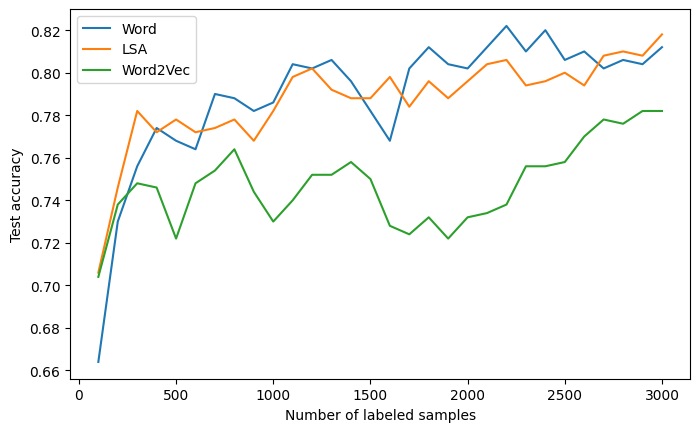

In [36]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figwidth(6)
fig.set_figwidth(8)
fig.set_dpi(100)

num_labeled = list(range(100, 3000+100, 100))

plt.plot(num_labeled, word_loss, label="Word")
plt.plot(num_labeled, lsa_loss, label="LSA")
plt.plot(num_labeled, w2v_loss, label="Word2Vec")

plt.xlabel("Number of labeled samples")
plt.ylabel("Test accuracy")

plt.legend(loc="upper left")